<font color=#8B4513 size=100 face="標楷體"> 抓資料 </font>

In [1951]:
import requests
import json
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
from sklearn import preprocessing
import math
import statsmodels.api as sm 
import scipy.stats as scs 
from scipy.fftpack import fft,ifft
from bs4 import BeautifulSoup as bs
import re
import datetime, time
import warnings
warnings.filterwarnings('ignore')

In [1952]:
#抓取股票清單
tai50 = "https://www.taifex.com.tw/cht/9/futuresQADetail"
response_tai50 = requests.get(tai50)
soup = bs(response_tai50.text)
stock_list = re.findall(r"[\d][\d][\d][\d][\ ]",soup.text)#抓出股票代碼的形式
stock_list = re.findall(r"[\d][\d][\d][\d]",str(stock_list[::2]))#取權重前450

In [2000]:
t = datetime.datetime.today()#抓日期
#int(time.mktime(t.timetuple()))yahoo財經的日期為秒,因此轉秒
names = locals()
for etf in stock_list:
    try:
        site = "https://query1.finance.yahoo.com/v7/finance/download/%s.TW?period1=1483228800&period2=%s&interval=1d&events=history"%(etf,int(time.mktime(t.timetuple())))
        response = requests.get(site)
        names["df_%s"%etf] = pd.read_csv(StringIO(response.text))
        names["df_%s"%etf] = names["df_%s"%etf].fillna(method='ffill')
        names["df_%s"%etf]["價格漲幅"]=names["df_%s"%etf]["Adj Close"].diff()
        names["df_%s"%etf]["成交量變動"]=names["df_%s"%etf]["Volume"].diff()
        names["df_%s"%etf] = names["df_%s"%etf].dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)    
        names["df_%s"%etf] = names["df_%s"%etf].rename(columns={
 'Open':'Open_%s'% etf,
 'High':'High_%s'% etf,
 'Low':'Low_%s'% etf,
 'Close':'Close_%s'% etf,
 'Adj Close':'Adj Close_%s'% etf,
 'Volume':'Volume_%s'% etf,
 '價格漲幅':'價格漲幅_%s'% etf,
 '漲幅...':'漲幅..._%s'% etf,
 '振幅...':'振幅..._%s'% etf,
 '成交量變動':'成交量變動_%s'% etf,})
    except:
        print(names["df_%s"%etf],"抓不到")
        pass

In [2001]:
#建立df清單
stock_df_list=[]
for stock in stock_list:
    stock_df ="df_"+stock
    stock_df_list.append(stock_df)

In [2002]:
#合併成一個df
all_stock_df=df_2330.iloc[:,[0]]
for stock_df in stock_df_list:
    all_stock_df = pd.merge(all_stock_df, names[stock_df], how='left', on='Date')

<font color=#8B4513 size=100 face="標楷體"> 資料預處理 </font>

In [1956]:
#向量自回歸抓領先變數
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.base.datetools import dates_from_str
import math
from statsmodels.tsa.vector_ar.hypothesis_test_results import \
    CausalityTestResults, NormalityTestResults, WhitenessTestResults
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy as sp

In [2003]:
#先把shift的收盤價帶入當成train
FITX["收盤價shift"] = FITX["收盤價"].shift()
all_stock_df["Date"] = all_stock_df["Date"].astype(str)
all_stock_df_FITX = all_stock_df
all_stock_df_FITX = pd.merge(all_stock_df_FITX, FITX.iloc[:,[0,19]], how='left', on='Date')

In [2004]:
print("目前資料共",df_2330.shape[0],"根日K")

目前資料共 834 根日K


In [2041]:

#逐一併入再找出有領先因子
#統計區間終點=日前日K-1
間隔 = 500
統計區間起點 = 統計區間終點-間隔
統計區間終點 =780     #樣本內
Significant_factor = df_2330.iloc[0:,[0]]
FITX_close = pd.read_csv(r"C:\Users\user\Desktop\class\金融\台指近.csv")
FITX_close = FITX_close.rename(columns={"時間":"Date"}).iloc[0:,[0,4]]
FITX_close["Date"] = pd.to_datetime(FITX_close["Date"])  #日期格式化
FITX_close["Date"] = FITX_close["Date"].astype(str)  #merge的那個形態要一樣
for i in stock_df_list:
    try:
        names['%s' % i]["Date"] = names['%s' % i]["Date"].astype(str)
        append_FITX = pd.merge(names['%s' % i], FITX_close, how='left', on='Date')
        model = VAR(append_FITX.iloc[統計區間起點:統計區間終點,1:append_FITX.shape[1]])  #用樣本內跑檢定,避免選擇性偏誤
        results = model.fit(1)
        for a in range(1,append_FITX.shape[1]-1):
            p_value = results.test_causality("收盤價",causing=append_FITX.iloc[:,[a]], kind='f', signif=0.1).pvalue
            if p_value<0.1:
                Significant_factor = pd.merge(Significant_factor, append_FITX.iloc[:,[0,a]], how='left', on='Date')
    except:
        pass
Significant_factor = Significant_factor.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)

# 共線性,去除vif>100的
cc = sp.corrcoef(Significant_factor.iloc[:,1:Significant_factor.shape[1]], rowvar=False)
VIF = np.linalg.inv(cc)
VIF_list=VIF.diagonal()
VIF_100 = np.where(VIF_list>100)    #找VIF>100的列
VIF_100 = VIF_100[0][1:]            #留日期
Significant_factor.drop(Significant_factor.iloc[:,1:Significant_factor.shape[1]].columns[VIF_100], axis=1,inplace=True)
Significant_factor.shape


print("顯著的因子有",Significant_factor.shape[1],"個")      

顯著的因子有 481 個


<font color=#8B4513 size=100 face="標楷體"> 建模ML </font>

In [2042]:
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, auc
import pandas as pd
import numpy as np
from sklearn.svm import SVC,SVR
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error,mean_absolute_error
from sklearn.svm import LinearSVR
from sklearn.datasets import make_regression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import NuSVR
from sklearn.tree import DecisionTreeRegressor
import sqlite3
from xgboost.sklearn import XGBRegressor

In [2043]:
"""
測試每個模型的準確度
樣本太少了,怕overfit暫時不調參數
"""
model_xgb = xgb.XGBRegressor()
model_RandomForestRegressor = RandomForestRegressor()
model_LinearSVR = LinearSVR()#不好
model_SVR = SVR()#不好
model_AdaBoostRegressor = AdaBoostRegressor(random_state=0, n_estimators=100)
model_BaggingRegressor = BaggingRegressor(base_estimator=SVR(),n_estimators=10, random_state=0)#不好
model_KernelRidge = KernelRidge()   #不能標準化與正規化,why?
model_NuSVR = NuSVR()#不好
# model_DecisionTreeRegressor = DecisionTreeRegressor()
Vote = VotingRegressor([("model_xgb",model_xgb),
                        ("model_RandomForestRegressor",model_RandomForestRegressor),
                        ("model_AdaBoostRegressor",model_AdaBoostRegressor),
#                        ("model_KNeighborsRegressor",model_KNeighborsRegressor),
#                        ("model_DecisionTreeRegressor",model_DecisionTreeRegressor)
                        ])
model_list = [Vote,model_xgb,model_RandomForestRegressor,model_LinearSVR,model_AdaBoostRegressor
              ]

In [2044]:
#合併
FITX = pd.read_csv(r"C:\Users\user\Desktop\class\金融\台指近.csv")
FITX = FITX.rename(columns={"時間":"Date"})
FITX["Date"] = pd.to_datetime(FITX["Date"])  #日期格式化
FITX["Date"] = FITX["Date"].astype(str)  #merge的那個形態要一樣
FITX["(期權)未平倉"] = FITX["(期權)未平倉"].str.replace("口","")
FITX["(期權)未平倉"] = FITX["(期權)未平倉"].astype(float)
FITX["(期權)未平倉變化"] = FITX["(期權)未平倉變化"].str.replace("口","")
FITX["(期權)未平倉變化"] = FITX["(期權)未平倉變化"].astype(float)
FITX["diff收盤價"] = FITX["收盤價"].diff()
FITX["Target"] = FITX["收盤價"].shift(-1)
FITX_target = FITX.iloc[:,[0,4,FITX.shape[1]-1]]
Significant_factor_test =  pd.merge(Significant_factor, FITX_target, how='left', on='Date')

#拆分訓練測試

all_feature= Significant_factor_test
train_data = all_feature.iloc[統計區間起點:統計區間終點,1:all_feature.shape[1]-1]
train_targets = all_feature.iloc[統計區間起點:統計區間終點,[all_feature.shape[1]-1]]
test_data = all_feature.iloc[統計區間終點:,1:all_feature.shape[1]-1]
test_targets = all_feature.iloc[統計區間終點:,all_feature.shape[1]-1]


In [2045]:
#訓練
#XGboost
model_xgb = xgb.XGBRegressor(
n_estimators =2000,
learning_rate =0.01,
max_depth=2000 ,
booster ="gbtree" ,
n_jobs = 500,

    
    
)

model_xgb.fit(train_data, train_targets)
y_pred = model_xgb.predict(test_data)
print(model,"平均誤差點數為",mae)

<statsmodels.tsa.vector_ar.var_model.VAR object at 0x0000026C63730E48> 平均誤差點數為 185.6991909969442


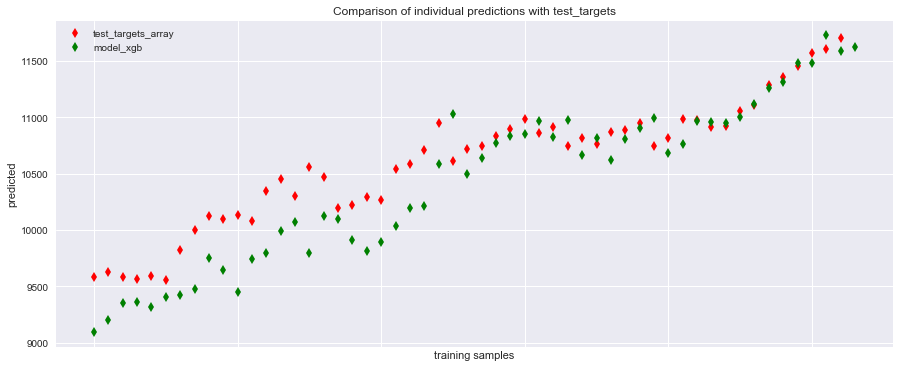

In [2046]:
#視覺化,紅色為標準答案
plt.style.use('seaborn')
test_targets_array=test_targets.values
plt.figure(figsize=(15, 6)) 
xt = test_data[:]
plt.plot(test_targets_array, 'rd', label='test_targets_array')
plt.plot(model_xgb.predict(xt), 'gd', label='model_xgb')
# plt.plot(model_AdaBoostRegressor.predict(xt), '#00008B', label='model_AdaBoostRegressor')
# plt.plot(Vote.predict(xt), 'bd', label='Vote')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions with test_targets')
plt.show()

In [2063]:
#預測結果
print("明天的預測價格是",y_pred[y_pred.shape[0]-1])
if (y_pred[y_pred.shape[0]-1] - y_pred[y_pred.shape[0]-2])>=0:
    print("上漲",y_pred[y_pred.shape[0]-1] - y_pred[y_pred.shape[0]-2],"點")
else:
    print("下跌",y_pred[y_pred.shape[0]-2] - y_pred[y_pred.shape[0]-1],"點")

明天的預測價格是 11622.679
上漲 37.30078 點


In [2067]:
#簡易回測,方法1  視預測值漲跌決定買賣
predict = model_xgb.predict(xt)
all_profit = 0
profit = 0
for i in range(1,len(predict)):
    if predict[i]>=predict[i-1]:
        profit = test_targets_array[i]-test_targets_array[i-1]
        all_profit+=profit
    else:
        profit = test_targets_array[i-1]-test_targets_array[i]
        all_profit+=profit
    print("第", i,"天積獲利",profit,"第", i,"天累積獲利",all_profit)
    

第 1 天積獲利 46.0 第 1 天累積獲利 46.0
第 2 天積獲利 -52.0 第 2 天累積獲利 -6.0
第 3 天積獲利 -13.0 第 3 天累積獲利 -19.0
第 4 天積獲利 -29.0 第 4 天累積獲利 -48.0
第 5 天積獲利 -40.0 第 5 天累積獲利 -88.0
第 6 天積獲利 268.0 第 6 天累積獲利 180.0
第 7 天積獲利 175.0 第 7 天累積獲利 355.0
第 8 天積獲利 124.0 第 8 天累積獲利 479.0
第 9 天積獲利 22.0 第 9 天累積獲利 501.0
第 10 天積獲利 -33.0 第 10 天累積獲利 468.0
第 11 天積獲利 -54.0 第 11 天累積獲利 414.0
第 12 天積獲利 264.0 第 12 天累積獲利 678.0
第 13 天積獲利 108.0 第 13 天累積獲利 786.0
第 14 天積獲利 -150.0 第 14 天累積獲利 636.0
第 15 天積獲利 -262.0 第 15 天累積獲利 374.0
第 16 天積獲利 -88.0 第 16 天累積獲利 286.0
第 17 天積獲利 279.0 第 17 天累積獲利 565.0
第 18 天積獲利 -26.0 第 18 天累積獲利 539.0
第 19 天積獲利 -70.0 第 19 天累積獲利 469.0
第 20 天積獲利 -24.0 第 20 天累積獲利 445.0
第 21 天積獲利 277.0 第 21 天累積獲利 722.0
第 22 天積獲利 38.0 第 22 天累積獲利 760.0
第 23 天積獲利 126.0 第 23 天累積獲利 886.0
第 24 天積獲利 238.0 第 24 天累積獲利 1124.0
第 25 天積獲利 -337.0 第 25 天累積獲利 787.0
第 26 天積獲利 -109.0 第 26 天累積獲利 678.0
第 27 天積獲利 30.0 第 27 天累積獲利 708.0
第 28 天積獲利 84.0 第 28 天累積獲利 792.0
第 29 天積獲利 61.0 第 29 天累積獲利 853.0
第 30 天積獲利 88.0 第 30 天累積獲利 941.0
第 31 天積獲利 -117.0 第 31 天累積獲利 824.

In [2068]:
#簡易回測,方法2  視預測值與實際值差額決定買賣
predict = model_xgb.predict(xt)
all_profit = 0
profit = 0
for i in range(1,len(predict)):
    if predict[i]>=test_targets_array[i-1]:
        profit = test_targets_array[i]-test_targets_array[i-1]
        all_profit+=profit
    else:
        profit = test_targets_array[i-1]-test_targets_array[i]
        all_profit+=profit
    all_profit+=profit
    print("第", i,"天累積獲利",all_profit)
    


第 1 天累積獲利 -92.0
第 2 天累積獲利 12.0
第 3 天累積獲利 38.0
第 4 天累積獲利 -20.0
第 5 天累積獲利 60.0
第 6 天累積獲利 -476.0
第 7 天累積獲利 -826.0
第 8 天累積獲利 -1074.0
第 9 天累積獲利 -1030.0
第 10 天累積獲利 -1096.0
第 11 天累積獲利 -988.0
第 12 天累積獲利 -1516.0
第 13 天累積獲利 -1732.0
第 14 天累積獲利 -1432.0
第 15 天累積獲利 -1956.0
第 16 天累積獲利 -1780.0
第 17 天累積獲利 -1222.0
第 18 天累積獲利 -1274.0
第 19 天累積獲利 -1414.0
第 20 天累積獲利 -1366.0
第 21 天累積獲利 -1920.0
第 22 天累積獲利 -1996.0
第 23 天累積獲利 -2248.0
第 24 天累積獲利 -2724.0
第 25 天累積獲利 -3398.0
第 26 天累積獲利 -3616.0
第 27 天累積獲利 -3676.0
第 28 天累積獲利 -3508.0
第 29 天累積獲利 -3386.0
第 30 天累積獲利 -3562.0
第 31 天累積獲利 -3328.0
第 32 天累積獲利 -3426.0
第 33 天累積獲利 -3756.0
第 34 天累積獲利 -3892.0
第 35 天累積獲利 -4004.0
第 36 天累積獲利 -4218.0
第 37 天累積獲利 -4256.0
第 38 天累積獲利 -4124.0
第 39 天累積獲利 -4542.0
第 40 天累積獲利 -4696.0
第 41 天累積獲利 -5022.0
第 42 天累積獲利 -5000.0
第 43 天累積獲利 -4876.0
第 44 天累積獲利 -4860.0
第 45 天累積獲利 -4584.0
第 46 天累積獲利 -4484.0
第 47 天累積獲利 -4132.0
第 48 天累積獲利 -3982.0
第 49 天累積獲利 -3784.0
第 50 天累積獲利 -3556.0
第 51 天累積獲利 -3478.0
第 52 天累積獲利 -3670.0
第 53 天累積獲利 nan


<font color=#8B4513 size=100 face="標楷體"> 建模DL </font>

In [ ]:

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

In [609]:
all_feature= Significant_factor_test
all_feature = all_feature.drop(columns=["Date"])
all_feature

,Volume_2330,成交量變動_2330,Low_6505,成交量變動_6505,成交量變動_2454,成交量變動_2882,Volume_2881,成交量變動_2881,Volume_2886,成交量變動_2886,...,成交量變動_3617,成交量變動_8996,High_1701,成交量變動_1701,成交量變動_1709,價格漲幅_2010,Volume_3530,價格漲幅_3454,收盤價,Target
0,24369000.0,1739000.0,108.000000,1288000.0,-71000.0,3499925.0,10406000.0,5136000.0,13865000.0,4862000.0,...,41000.0,271000.0,18.250000,38000.0,-232638.0,0.042661,17201.0,-0.244285,9271.0,9342.0
1,20979000.0,-3390000.0,108.000000,-309000.0,315000.0,5123312.0,10166000.0,-240000.0,17662000.0,3797000.0,...,9000.0,-196000.0,18.250000,64000.0,360786.0,0.000000,5400.0,0.000000,9342.0,9365.0
2,22443000.0,1464000.0,108.500000,-1788000.0,599000.0,1482747.0,6993000.0,-3173000.0,11226000.0,-6436000.0,...,-47000.0,-41000.0,18.200001,-13000.0,-325299.0,0.000000,4000.0,-1.221344,9365.0,9342.0
3,18569000.0,-3874000.0,109.000000,244000.0,-1805000.0,-1105028.0,13755000.0,6762000.0,9055000.0,-2171000.0,...,142000.0,-34000.0,18.250000,-71000.0,235596.0,0.085321,58260.0,0.895691,9342.0,9341.0
4,20198000.0,1629000.0,107.500000,1599000.0,1513000.0,-684113.0,10076000.0,-3679000.0,13438000.0,4383000.0,...,118000.0,60000.0,18.250000,55000.0,-103505.0,-0.085321,13100.0,-0.162827,9341.0,9337.0
5,29107000.0,8909000.0,107.500000,-1410000.0,13000.0,2134713.0,9462000.0,-614000.0,13908000.0,470000.0,...,-75000.0,-84000.0,18.100000,-58000.0,376559.0,0.085321,56230.0,-0.651405,9337.0,9411.0
6,41130000.0,12023000.0,108.000000,646000.0,-1253000.0,1938822.0,15440000.0,5978000.0,16765000.0,2857000.0,...,-94000.0,-27000.0,18.100000,17000.0,-327271.0,0.085319,4050.0,0.000000,9411.0,9375.0
7,52352000.0,11222000.0,108.000000,-1281000.0,1009000.0,-2220101.0,12490000.0,-2950000.0,11565000.0,-5200000.0,...,361000.0,17000.0,18.100000,-21000.0,-58159.0,-0.042661,6610.0,-0.407112,9375.0,9285.0
8,30756000.0,-21596000.0,104.000000,2859000.0,1114000.0,5643679.0,11326000.0,-1164000.0,10179000.0,-1386000.0,...,-384000.0,-2000.0,18.100000,69000.0,29572.0,0.000000,19000.0,-0.977074,9285.0,9340.0
9,13159000.0,-17597000.0,104.000000,-1569000.0,-1607000.0,-4130796.0,8636000.0,-2690000.0,13976000.0,3797000.0,...,131000.0,-35000.0,18.049999,37000.0,-105476.0,0.042661,10000.0,0.569954,9340.0,9340.0


In [610]:
def buildTrain(train, pastDay=30, futureDay=5):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["Target"]))
    return np.array(X_train), np.array(Y_train)

In [612]:
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [649]:


# build Data, use last 30 days to predict next 5 days
X_train, Y_train = buildTrain(all_feature, 30, 5)

# shuffle the data, and random seed is 10
X_train, Y_train = shuffle(X_train, Y_train)

# split training data and validation data
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
# X_trian: (5710, 30, 10)
# Y_train: (5710, 5, 1)
# X_val: (634, 30, 10)
# Y_val: (634, 5, 1)
print("X_train",X_train.shape)
print("Y_train",Y_train.shape)
print("X_val",X_val.shape)
print("Y_val",Y_val.shape)

X_train (712, 30, 221)
Y_train (712, 5)
X_val (79, 30, 221)
Y_val (79, 5)


In [635]:
def buildOneToOneModel(shape):
    model = Sequential()
    model.add(LSTM(250, input_length=shape[1], input_dim=shape[2],return_sequences=True))
    model.add(LSTM(100,return_sequences=True))
    # output shape: (1, 1)
    model.add(TimeDistributed(Dense(1)))    # or use model.add(Dense(1))
    model.compile(loss="mae", optimizer="adam")
    model.summary()
    return model

In [648]:
Y_train.shape

(742, 1, 1)

In [653]:
# change the last day and next day 
X_train, Y_train = buildTrain(all_feature, 1, 1)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

# from 2 dimmension to 3 dimension
Y_train = Y_train[:,np.newaxis]
Y_val = Y_val[:,np.newaxis]

model = Sequential()
model.add(LSTM(250, input_length=X_train .shape[1], input_dim=X_train .shape[2],return_sequences=True))
model.add(LSTM(100,return_sequences=True))
# output shape: (1, 1)
model.add(TimeDistributed(Dense(1)))    # or use model.add(Dense(1))
model.compile(loss="mae", optimizer="adam")
model.summary()

model.fit(X_train, Y_train, epochs=3000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(250, return_sequences=True, input_shape=(1, 221))`
  # This is added back by InteractiveShellApp.init_path()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 1, 250)            472000    
_________________________________________________________________
lstm_15 (LSTM)               (None, 1, 100)            140400    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 1, 1)              101       
Total params: 612,501
Trainable params: 612,501
Non-trainable params: 0
_________________________________________________________________
Train on 742 samples, validate on 82 samples
Epoch 1/3000
742/742 [==============================] - 1s 1ms/step - loss: 10568.5608 - val_loss: 10539.7627
Epoch 2/3000
742/742 [==============================] - 0s 116us/step - loss: 10568.0194 - val_loss: 10539.1650
Epoch 3/3000
742/742 [==============================] - 0s 116us/step - loss: 10567.3771 - val_loss: 10538.437

742/742 [==============================] - 0s 114us/step - loss: 10487.8559 - val_loss: 10459.0322
Epoch 139/3000
742/742 [==============================] - 0s 111us/step - loss: 10487.3718 - val_loss: 10458.5488
Epoch 140/3000
742/742 [==============================] - 0s 103us/step - loss: 10486.8885 - val_loss: 10458.0654
Epoch 141/3000
742/742 [==============================] - 0s 122us/step - loss: 10486.4051 - val_loss: 10457.5820
Epoch 142/3000
742/742 [==============================] - 0s 132us/step - loss: 10485.9218 - val_loss: 10457.1006
Epoch 143/3000
742/742 [==============================] - 0s 126us/step - loss: 10485.4386 - val_loss: 10456.6172
Epoch 144/3000
742/742 [==============================] - 0s 128us/step - loss: 10484.9555 - val_loss: 10456.1357
Epoch 145/3000
742/742 [==============================] - 0s 99us/step - loss: 10484.4733 - val_loss: 10455.6533
Epoch 146/3000
742/742 [==============================] - 0s 91us/step - loss: 10483.9907 - val_loss: 10

742/742 [==============================] - 0s 89us/step - loss: 10419.5224 - val_loss: 10390.7393
Epoch 283/3000
742/742 [==============================] - 0s 87us/step - loss: 10419.0538 - val_loss: 10390.2695
Epoch 284/3000
742/742 [==============================] - 0s 91us/step - loss: 10418.5845 - val_loss: 10389.8008
Epoch 285/3000
742/742 [==============================] - 0s 91us/step - loss: 10418.1155 - val_loss: 10389.3330
Epoch 286/3000
742/742 [==============================] - 0s 87us/step - loss: 10417.6463 - val_loss: 10388.8643
Epoch 287/3000
742/742 [==============================] - 0s 91us/step - loss: 10417.1779 - val_loss: 10388.3955
Epoch 288/3000
742/742 [==============================] - 0s 87us/step - loss: 10416.7091 - val_loss: 10387.9268
Epoch 289/3000
742/742 [==============================] - 0s 89us/step - loss: 10416.2407 - val_loss: 10387.4580
Epoch 290/3000
742/742 [==============================] - 0s 87us/step - loss: 10415.7719 - val_loss: 10386.989

742/742 [==============================] - 0s 87us/step - loss: 10352.3003 - val_loss: 10323.5273
Epoch 427/3000
742/742 [==============================] - 0s 89us/step - loss: 10351.8351 - val_loss: 10323.0615
Epoch 428/3000
742/742 [==============================] - 0s 90us/step - loss: 10351.3707 - val_loss: 10322.5967
Epoch 429/3000
742/742 [==============================] - 0s 89us/step - loss: 10350.9048 - val_loss: 10322.1309
Epoch 430/3000
742/742 [==============================] - 0s 89us/step - loss: 10350.4393 - val_loss: 10321.6660
Epoch 431/3000
742/742 [==============================] - 0s 90us/step - loss: 10349.9744 - val_loss: 10321.2002
Epoch 432/3000
742/742 [==============================] - 0s 90us/step - loss: 10349.5095 - val_loss: 10320.7363
Epoch 433/3000
742/742 [==============================] - 0s 89us/step - loss: 10349.0445 - val_loss: 10320.2715
Epoch 434/3000
742/742 [==============================] - 0s 89us/step - loss: 10348.5785 - val_loss: 10319.806

742/742 [==============================] - 0s 89us/step - loss: 10285.4148 - val_loss: 10256.6426
Epoch 571/3000
742/742 [==============================] - 0s 86us/step - loss: 10284.9512 - val_loss: 10256.1797
Epoch 572/3000
742/742 [==============================] - 0s 87us/step - loss: 10284.4866 - val_loss: 10255.7168
Epoch 573/3000
742/742 [==============================] - 0s 86us/step - loss: 10284.0231 - val_loss: 10255.2520
Epoch 574/3000
742/742 [==============================] - 0s 86us/step - loss: 10283.5596 - val_loss: 10254.7900
Epoch 575/3000
742/742 [==============================] - 0s 87us/step - loss: 10283.0951 - val_loss: 10254.3242
Epoch 576/3000
742/742 [==============================] - 0s 86us/step - loss: 10282.6312 - val_loss: 10253.8604
Epoch 577/3000
742/742 [==============================] - 0s 86us/step - loss: 10282.1677 - val_loss: 10253.3975
Epoch 578/3000
742/742 [==============================] - 0s 86us/step - loss: 10281.7037 - val_loss: 10252.932

742/742 [==============================] - 0s 90us/step - loss: 10218.6565 - val_loss: 10189.8867
Epoch 715/3000
742/742 [==============================] - 0s 92us/step - loss: 10218.1941 - val_loss: 10189.4238
Epoch 716/3000
742/742 [==============================] - 0s 87us/step - loss: 10217.7300 - val_loss: 10188.9600
Epoch 717/3000
742/742 [==============================] - 0s 87us/step - loss: 10217.2659 - val_loss: 10188.4951
Epoch 718/3000
742/742 [==============================] - 0s 87us/step - loss: 10216.8039 - val_loss: 10188.0332
Epoch 719/3000
742/742 [==============================] - 0s 89us/step - loss: 10216.3391 - val_loss: 10187.5703
Epoch 720/3000
742/742 [==============================] - 0s 90us/step - loss: 10215.8759 - val_loss: 10187.1064
Epoch 721/3000
742/742 [==============================] - 0s 86us/step - loss: 10215.4136 - val_loss: 10186.6426
Epoch 722/3000
742/742 [==============================] - 0s 90us/step - loss: 10214.9490 - val_loss: 10186.179

742/742 [==============================] - 0s 122us/step - loss: 10151.9516 - val_loss: 10123.1816
Epoch 859/3000
742/742 [==============================] - 0s 118us/step - loss: 10151.4893 - val_loss: 10122.7188
Epoch 860/3000
742/742 [==============================] - 0s 122us/step - loss: 10151.0250 - val_loss: 10122.2559
Epoch 861/3000
742/742 [==============================] - 0s 122us/step - loss: 10150.5623 - val_loss: 10121.7939
Epoch 862/3000
742/742 [==============================] - 0s 122us/step - loss: 10150.0994 - val_loss: 10121.3281
Epoch 863/3000
742/742 [==============================] - 0s 122us/step - loss: 10149.6352 - val_loss: 10120.8662
Epoch 864/3000
742/742 [==============================] - 0s 126us/step - loss: 10149.1732 - val_loss: 10120.4043
Epoch 865/3000
742/742 [==============================] - 0s 120us/step - loss: 10148.7096 - val_loss: 10119.9395
Epoch 866/3000
742/742 [==============================] - 0s 122us/step - loss: 10148.2460 - val_loss: 

742/742 [==============================] - 0s 90us/step - loss: 10118.6042 - val_loss: 10089.8350
Epoch 931/3000
742/742 [==============================] - 0s 91us/step - loss: 10118.1422 - val_loss: 10089.3721
Epoch 932/3000
742/742 [==============================] - 0s 93us/step - loss: 10117.6780 - val_loss: 10088.9082
Epoch 933/3000
742/742 [==============================] - 0s 102us/step - loss: 10117.2146 - val_loss: 10088.4453
Epoch 934/3000
742/742 [==============================] - 0s 94us/step - loss: 10116.7527 - val_loss: 10087.9834
Epoch 935/3000
742/742 [==============================] - 0s 97us/step - loss: 10116.2881 - val_loss: 10087.5195
Epoch 936/3000
742/742 [==============================] - 0s 98us/step - loss: 10115.8258 - val_loss: 10087.0557
Epoch 937/3000
742/742 [==============================] - 0s 94us/step - loss: 10115.3628 - val_loss: 10086.5918
Epoch 938/3000
742/742 [==============================] - 0s 95us/step - loss: 10114.8987 - val_loss: 10086.12

742/742 [==============================] - 0s 122us/step - loss: 10052.3942 - val_loss: 10023.6230
Epoch 1074/3000
742/742 [==============================] - 0s 122us/step - loss: 10051.9305 - val_loss: 10023.1611
Epoch 1075/3000
742/742 [==============================] - 0s 118us/step - loss: 10051.4685 - val_loss: 10022.6992
Epoch 1076/3000
742/742 [==============================] - 0s 120us/step - loss: 10051.0046 - val_loss: 10022.2354
Epoch 1077/3000
742/742 [==============================] - 0s 120us/step - loss: 10050.5418 - val_loss: 10021.7725
Epoch 1078/3000
742/742 [==============================] - 0s 121us/step - loss: 10050.0800 - val_loss: 10021.3096
Epoch 1079/3000
742/742 [==============================] - 0s 118us/step - loss: 10049.6159 - val_loss: 10020.8477
Epoch 1080/3000
742/742 [==============================] - 0s 117us/step - loss: 10049.1534 - val_loss: 10020.3848
Epoch 1081/3000
742/742 [==============================] - 0s 126us/step - loss: 10048.6910 - va

742/742 [==============================] - 0s 106us/step - loss: 9986.1946 - val_loss: 9957.4258
Epoch 1217/3000
742/742 [==============================] - 0s 109us/step - loss: 9985.7330 - val_loss: 9956.9639
Epoch 1218/3000
742/742 [==============================] - 0s 108us/step - loss: 9985.2692 - val_loss: 9956.4980
Epoch 1219/3000
742/742 [==============================] - 0s 99us/step - loss: 9984.8052 - val_loss: 9956.0361
Epoch 1220/3000
742/742 [==============================] - 0s 112us/step - loss: 9984.3441 - val_loss: 9955.5742
Epoch 1221/3000
742/742 [==============================] - 0s 114us/step - loss: 9983.8796 - val_loss: 9955.1133
Epoch 1222/3000
742/742 [==============================] - 0s 119us/step - loss: 9983.4173 - val_loss: 9954.6475
Epoch 1223/3000
742/742 [==============================] - 0s 113us/step - loss: 9982.9547 - val_loss: 9954.1846
Epoch 1224/3000
742/742 [==============================] - 0s 110us/step - loss: 9982.4907 - val_loss: 9953.7217


742/742 [==============================] - 0s 128us/step - loss: 9919.5186 - val_loss: 9890.7480
Epoch 1361/3000
742/742 [==============================] - 0s 129us/step - loss: 9919.0543 - val_loss: 9890.2842
Epoch 1362/3000
742/742 [==============================] - 0s 122us/step - loss: 9918.5925 - val_loss: 9889.8232
Epoch 1363/3000
742/742 [==============================] - 0s 133us/step - loss: 9918.1279 - val_loss: 9889.3584
Epoch 1364/3000
742/742 [==============================] - 0s 149us/step - loss: 9917.6650 - val_loss: 9888.8955
Epoch 1365/3000
742/742 [==============================] - 0s 152us/step - loss: 9917.2031 - val_loss: 9888.4326
Epoch 1366/3000
742/742 [==============================] - 0s 144us/step - loss: 9916.7388 - val_loss: 9887.9707
Epoch 1367/3000
742/742 [==============================] - 0s 126us/step - loss: 9916.2757 - val_loss: 9887.5059
Epoch 1368/3000
742/742 [==============================] - 0s 124us/step - loss: 9915.8134 - val_loss: 9887.0430

742/742 [==============================] - 0s 112us/step - loss: 9852.8259 - val_loss: 9824.0566
Epoch 1505/3000
742/742 [==============================] - 0s 116us/step - loss: 9852.3621 - val_loss: 9823.5918
Epoch 1506/3000
742/742 [==============================] - 0s 121us/step - loss: 9851.8983 - val_loss: 9823.1279
Epoch 1507/3000
742/742 [==============================] - 0s 118us/step - loss: 9851.4359 - val_loss: 9822.6660
Epoch 1508/3000
742/742 [==============================] - 0s 116us/step - loss: 9850.9723 - val_loss: 9822.2041
Epoch 1509/3000
742/742 [==============================] - 0s 126us/step - loss: 9850.5095 - val_loss: 9821.7383
Epoch 1510/3000
742/742 [==============================] - 0s 118us/step - loss: 9850.0466 - val_loss: 9821.2764
Epoch 1511/3000
742/742 [==============================] - 0s 117us/step - loss: 9849.5825 - val_loss: 9820.8145
Epoch 1512/3000
742/742 [==============================] - 0s 124us/step - loss: 9849.1194 - val_loss: 9820.3506

742/742 [==============================] - 0s 138us/step - loss: 9786.1316 - val_loss: 9757.3633
Epoch 1649/3000
742/742 [==============================] - 0s 136us/step - loss: 9785.6697 - val_loss: 9756.9004
Epoch 1650/3000
742/742 [==============================] - 0s 132us/step - loss: 9785.2057 - val_loss: 9756.4355
Epoch 1651/3000
742/742 [==============================] - 0s 138us/step - loss: 9784.7425 - val_loss: 9755.9717
Epoch 1652/3000
742/742 [==============================] - 0s 128us/step - loss: 9784.2807 - val_loss: 9755.5088
Epoch 1653/3000
742/742 [==============================] - 0s 132us/step - loss: 9783.8159 - val_loss: 9755.0469
Epoch 1654/3000
742/742 [==============================] - 0s 137us/step - loss: 9783.3532 - val_loss: 9754.5830
Epoch 1655/3000
742/742 [==============================] - 0s 126us/step - loss: 9782.8910 - val_loss: 9754.1201
Epoch 1656/3000
742/742 [==============================] - 0s 124us/step - loss: 9782.4267 - val_loss: 9753.6582

742/742 [==============================] - 0s 103us/step - loss: 9718.9760 - val_loss: 9690.2070
Epoch 1794/3000
742/742 [==============================] - 0s 106us/step - loss: 9718.5141 - val_loss: 9689.7441
Epoch 1795/3000
742/742 [==============================] - 0s 97us/step - loss: 9718.0495 - val_loss: 9689.2793
Epoch 1796/3000
742/742 [==============================] - 0s 97us/step - loss: 9717.5860 - val_loss: 9688.8154
Epoch 1797/3000
742/742 [==============================] - 0s 101us/step - loss: 9717.1244 - val_loss: 9688.3535
Epoch 1798/3000
742/742 [==============================] - 0s 101us/step - loss: 9716.6599 - val_loss: 9687.8926
Epoch 1799/3000
742/742 [==============================] - 0s 114us/step - loss: 9716.1971 - val_loss: 9687.4268
Epoch 1800/3000
742/742 [==============================] - 0s 116us/step - loss: 9715.7346 - val_loss: 9686.9639
Epoch 1801/3000
742/742 [==============================] - 0s 90us/step - loss: 9715.2707 - val_loss: 9686.5020
Ep

Epoch 1866/3000
742/742 [==============================] - 0s 119us/step - loss: 9685.1667 - val_loss: 9656.3975
Epoch 1867/3000
742/742 [==============================] - 0s 103us/step - loss: 9684.7044 - val_loss: 9655.9326
Epoch 1868/3000
742/742 [==============================] - 0s 118us/step - loss: 9684.2396 - val_loss: 9655.4707
Epoch 1869/3000
742/742 [==============================] - 0s 103us/step - loss: 9683.7769 - val_loss: 9655.0078
Epoch 1870/3000
742/742 [==============================] - 0s 116us/step - loss: 9683.3143 - val_loss: 9654.5439
Epoch 1871/3000
742/742 [==============================] - 0s 97us/step - loss: 9682.8504 - val_loss: 9654.0801
Epoch 1872/3000
742/742 [==============================] - 0s 99us/step - loss: 9682.3883 - val_loss: 9653.6191
Epoch 1873/3000
742/742 [==============================] - 0s 99us/step - loss: 9681.9244 - val_loss: 9653.1543
Epoch 1874/3000
742/742 [==============================] - 0s 99us/step - loss: 9681.4609 - val_los

Epoch 1939/3000
742/742 [==============================] - 0s 90us/step - loss: 9651.3576 - val_loss: 9622.5879
Epoch 1940/3000
742/742 [==============================] - 0s 89us/step - loss: 9650.8937 - val_loss: 9622.1250
Epoch 1941/3000
742/742 [==============================] - 0s 90us/step - loss: 9650.4306 - val_loss: 9621.6592
Epoch 1942/3000
742/742 [==============================] - 0s 91us/step - loss: 9649.9685 - val_loss: 9621.1963
Epoch 1943/3000
742/742 [==============================] - 0s 89us/step - loss: 9649.5037 - val_loss: 9620.7363
Epoch 1944/3000
742/742 [==============================] - 0s 90us/step - loss: 9649.0412 - val_loss: 9620.2725
Epoch 1945/3000
742/742 [==============================] - 0s 87us/step - loss: 9648.5791 - val_loss: 9619.8076
Epoch 1946/3000
742/742 [==============================] - 0s 87us/step - loss: 9648.1142 - val_loss: 9619.3457
Epoch 1947/3000
742/742 [==============================] - 0s 90us/step - loss: 9647.6520 - val_loss: 96

742/742 [==============================] - 0s 101us/step - loss: 9617.5483 - val_loss: 9588.7764
Epoch 2013/3000
742/742 [==============================] - 0s 98us/step - loss: 9617.0841 - val_loss: 9588.3145
Epoch 2014/3000
742/742 [==============================] - 0s 99us/step - loss: 9616.6222 - val_loss: 9587.8525
Epoch 2015/3000
742/742 [==============================] - 0s 90us/step - loss: 9616.1583 - val_loss: 9587.3877
Epoch 2016/3000
742/742 [==============================] - 0s 91us/step - loss: 9615.6942 - val_loss: 9586.9258
Epoch 2017/3000
742/742 [==============================] - 0s 95us/step - loss: 9615.2324 - val_loss: 9586.4629
Epoch 2018/3000
742/742 [==============================] - 0s 99us/step - loss: 9614.7687 - val_loss: 9585.9980
Epoch 2019/3000
742/742 [==============================] - 0s 97us/step - loss: 9614.3053 - val_loss: 9585.5342
Epoch 2020/3000
742/742 [==============================] - 0s 91us/step - loss: 9613.8432 - val_loss: 9585.0713
Epoch 2

Epoch 2158/3000
742/742 [==============================] - 0s 134us/step - loss: 9549.9279 - val_loss: 9521.1582
Epoch 2159/3000
742/742 [==============================] - 0s 117us/step - loss: 9549.4658 - val_loss: 9520.6963
Epoch 2160/3000
742/742 [==============================] - 0s 102us/step - loss: 9549.0025 - val_loss: 9520.2314
Epoch 2161/3000
742/742 [==============================] - 0s 103us/step - loss: 9548.5390 - val_loss: 9519.7695
Epoch 2162/3000
742/742 [==============================] - 0s 109us/step - loss: 9548.0769 - val_loss: 9519.3066
Epoch 2163/3000
742/742 [==============================] - 0s 113us/step - loss: 9547.6123 - val_loss: 9518.8438
Epoch 2164/3000
742/742 [==============================] - 0s 109us/step - loss: 9547.1497 - val_loss: 9518.3799
Epoch 2165/3000
742/742 [==============================] - 0s 105us/step - loss: 9546.6875 - val_loss: 9517.9160
Epoch 2166/3000
742/742 [==============================] - 0s 126us/step - loss: 9546.2227 - val

Epoch 2231/3000
742/742 [==============================] - 0s 101us/step - loss: 9516.1189 - val_loss: 9487.3496
Epoch 2232/3000
742/742 [==============================] - 0s 102us/step - loss: 9515.6569 - val_loss: 9486.8867
Epoch 2233/3000
742/742 [==============================] - 0s 103us/step - loss: 9515.1924 - val_loss: 9486.4238
Epoch 2234/3000
742/742 [==============================] - 0s 99us/step - loss: 9514.7297 - val_loss: 9485.9600
Epoch 2235/3000
742/742 [==============================] - 0s 97us/step - loss: 9514.2669 - val_loss: 9485.4951
Epoch 2236/3000
742/742 [==============================] - 0s 97us/step - loss: 9513.8026 - val_loss: 9485.0332
Epoch 2237/3000
742/742 [==============================] - 0s 105us/step - loss: 9513.3408 - val_loss: 9484.5713
Epoch 2238/3000
742/742 [==============================] - 0s 97us/step - loss: 9512.8769 - val_loss: 9484.1064
Epoch 2239/3000
742/742 [==============================] - 0s 98us/step - loss: 9512.4133 - val_loss

Epoch 2304/3000
742/742 [==============================] - 0s 91us/step - loss: 9482.3105 - val_loss: 9453.5400
Epoch 2305/3000
742/742 [==============================] - 0s 94us/step - loss: 9481.8461 - val_loss: 9453.0752
Epoch 2306/3000
742/742 [==============================] - 0s 112us/step - loss: 9481.3827 - val_loss: 9452.6133
Epoch 2307/3000
742/742 [==============================] - 0s 91us/step - loss: 9480.9208 - val_loss: 9452.1504
Epoch 2308/3000
742/742 [==============================] - 0s 86us/step - loss: 9480.4569 - val_loss: 9451.6885
Epoch 2309/3000
742/742 [==============================] - 0s 89us/step - loss: 9479.9937 - val_loss: 9451.2236
Epoch 2310/3000
742/742 [==============================] - 0s 91us/step - loss: 9479.5312 - val_loss: 9450.7617
Epoch 2311/3000
742/742 [==============================] - 0s 91us/step - loss: 9479.0674 - val_loss: 9450.2988
Epoch 2312/3000
742/742 [==============================] - 0s 93us/step - loss: 9478.6044 - val_loss: 9

742/742 [==============================] - 0s 118us/step - loss: 9415.6160 - val_loss: 9386.8467
Epoch 2449/3000
742/742 [==============================] - 0s 114us/step - loss: 9415.1543 - val_loss: 9386.3838
Epoch 2450/3000
742/742 [==============================] - 0s 114us/step - loss: 9414.6904 - val_loss: 9385.9219
Epoch 2451/3000
742/742 [==============================] - 0s 121us/step - loss: 9414.2276 - val_loss: 9385.4570
Epoch 2452/3000
742/742 [==============================] - 0s 124us/step - loss: 9413.7646 - val_loss: 9384.9941
Epoch 2453/3000
742/742 [==============================] - 0s 126us/step - loss: 9413.3005 - val_loss: 9384.5322
Epoch 2454/3000
742/742 [==============================] - 0s 132us/step - loss: 9412.8379 - val_loss: 9384.0684
Epoch 2455/3000
742/742 [==============================] - 0s 127us/step - loss: 9412.3759 - val_loss: 9383.6055
Epoch 2456/3000
742/742 [==============================] - 0s 123us/step - loss: 9411.9112 - val_loss: 9383.1426

742/742 [==============================] - 0s 123us/step - loss: 9348.9242 - val_loss: 9320.1533
Epoch 2593/3000
742/742 [==============================] - 0s 121us/step - loss: 9348.4607 - val_loss: 9319.6904
Epoch 2594/3000
742/742 [==============================] - 0s 121us/step - loss: 9347.9980 - val_loss: 9319.2285
Epoch 2595/3000
742/742 [==============================] - 0s 125us/step - loss: 9347.5342 - val_loss: 9318.7656
Epoch 2596/3000
742/742 [==============================] - 0s 125us/step - loss: 9347.0716 - val_loss: 9318.3008
Epoch 2597/3000
742/742 [==============================] - 0s 123us/step - loss: 9346.6092 - val_loss: 9317.8379
Epoch 2598/3000
742/742 [==============================] - 0s 115us/step - loss: 9346.1444 - val_loss: 9317.3760
Epoch 2599/3000
742/742 [==============================] - 0s 117us/step - loss: 9345.6820 - val_loss: 9316.9121
Epoch 2600/3000
742/742 [==============================] - 0s 118us/step - loss: 9345.2197 - val_loss: 9316.4492

742/742 [==============================] - 0s 135us/step - loss: 9282.2812 - val_loss: 9253.5117
Epoch 2737/3000
742/742 [==============================] - 0s 158us/step - loss: 9281.8182 - val_loss: 9253.0488
Epoch 2738/3000
742/742 [==============================] - 0s 149us/step - loss: 9281.3558 - val_loss: 9252.5869
Epoch 2739/3000
742/742 [==============================] - 0s 129us/step - loss: 9280.8930 - val_loss: 9252.1221
Epoch 2740/3000
742/742 [==============================] - 0s 116us/step - loss: 9280.4299 - val_loss: 9251.6582
Epoch 2741/3000
742/742 [==============================] - 0s 124us/step - loss: 9279.9678 - val_loss: 9251.1982
Epoch 2742/3000
742/742 [==============================] - 0s 126us/step - loss: 9279.5046 - val_loss: 9250.7354
Epoch 2743/3000
742/742 [==============================] - 0s 147us/step - loss: 9279.0423 - val_loss: 9250.2734
Epoch 2744/3000
742/742 [==============================] - 0s 112us/step - loss: 9278.5796 - val_loss: 9249.8096

Epoch 2809/3000
742/742 [==============================] - 0s 101us/step - loss: 9248.5030 - val_loss: 9219.7354
Epoch 2810/3000
742/742 [==============================] - 0s 95us/step - loss: 9248.0407 - val_loss: 9219.2725
Epoch 2811/3000
742/742 [==============================] - 0s 97us/step - loss: 9247.5791 - val_loss: 9218.8076
Epoch 2812/3000
742/742 [==============================] - 0s 95us/step - loss: 9247.1152 - val_loss: 9218.3457
Epoch 2813/3000
742/742 [==============================] - 0s 98us/step - loss: 9246.6539 - val_loss: 9217.8838
Epoch 2814/3000
742/742 [==============================] - 0s 93us/step - loss: 9246.1899 - val_loss: 9217.4219
Epoch 2815/3000
742/742 [==============================] - 0s 95us/step - loss: 9245.7279 - val_loss: 9216.9580
Epoch 2816/3000
742/742 [==============================] - 0s 94us/step - loss: 9245.2655 - val_loss: 9216.4951
Epoch 2817/3000
742/742 [==============================] - 0s 97us/step - loss: 9244.8017 - val_loss: 9

742/742 [==============================] - 0s 98us/step - loss: 9214.7264 - val_loss: 9185.9561
Epoch 2883/3000
742/742 [==============================] - 0s 94us/step - loss: 9214.2642 - val_loss: 9185.4941
Epoch 2884/3000
742/742 [==============================] - 0s 94us/step - loss: 9213.8005 - val_loss: 9185.0322
Epoch 2885/3000
742/742 [==============================] - 0s 93us/step - loss: 9213.3381 - val_loss: 9184.5684
Epoch 2886/3000
742/742 [==============================] - 0s 91us/step - loss: 9212.8760 - val_loss: 9184.1064
Epoch 2887/3000
742/742 [==============================] - 0s 91us/step - loss: 9212.4124 - val_loss: 9183.6426
Epoch 2888/3000
742/742 [==============================] - 0s 97us/step - loss: 9211.9507 - val_loss: 9183.1807
Epoch 2889/3000
742/742 [==============================] - 0s 90us/step - loss: 9211.4869 - val_loss: 9182.7188
Epoch 2890/3000
742/742 [==============================] - 0s 94us/step - loss: 9211.0248 - val_loss: 9182.2559
Epoch 28

In [651]:
loss = history.history['loss']
loss

[10562.470658854167,
 10562.470661458334,
 10562.470669270833,
 10562.470671875,
 10562.470666666666,
 10562.4706640625,
 10562.470674479167,
 10562.470671875,
 10562.470669270833,
 10562.470669270833,
 10562.470661458334,
 10562.4706640625,
 10562.470666666666,
 10562.470669270833,
 10562.470669270833,
 10562.470669270833,
 10562.470674479167,
 10562.470666666666,
 10562.470661458334,
 10562.470669270833,
 10562.470666666666,
 10562.470674479167,
 10562.470669270833,
 10562.4706640625,
 10562.470671875,
 10562.470671875,
 10562.470661458334,
 10562.470661458334,
 10562.470669270833,
 10562.4706640625,
 10562.470658854167,
 10562.4706640625,
 10562.4706640625,
 10562.470658854167,
 10562.470666666666,
 10562.470669270833,
 10562.470669270833,
 10562.470669270833,
 10562.4706640625,
 10562.4706640625,
 10562.470671875,
 10562.470669270833,
 10562.470661458334,
 10562.470658854167,
 10562.470661458334,
 10562.470669270833,
 10562.470674479167,
 10562.470666666666,
 10562.4706640625,
 105

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 35347 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 32244 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 33287 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 39511 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 35657 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30340 missing from c

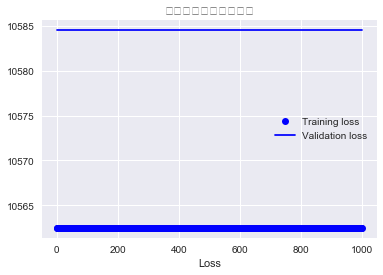

In [637]:
#繪圖

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+ 1)
plt.plot(epochs, loss,'bo',label='Training loss')
plt.plot(epochs, val_loss,'b',label='Validation loss')
plt.title('訓練與驗證的損失函數')
plt.xlabel('Epohs')
plt.xlabel('Loss')
plt.legend()
plt.show()

In [340]:
#PCA
"""
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
x = X_scaler.fit_transform(fdsd.iloc[:,1:Significant_factor.shape[1]])
# PCA
pca = PCA(n_components=0.9)# 保證降維後的資料保持90%的資訊
pca.fit(x)
asas = pca.transform(x)